## Project: Dog Breed Classifier



### Outline

The notebook is broken down into separate steps.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step6): Write Dog Breed Classifier Algorithm
* [Step 6](#step7): Test Dog Breed Classifier Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %d total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


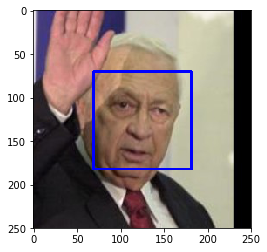

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[5])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Test the Human Face Detector

Using the code cell below we can test the performance of the `face_detector` function.  

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

After testing you can see that 99% of the first 100 images in human_files have a detected human face, while 11% of the first 100 images in dog_files have a detected human face.

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

human_count = 0
total = 0
for img in human_files_short:
    isPerson = face_detector(img)
    if not isPerson:
        human_count += 1
        total = 100 - human_count
    percentage = (total/len(human_files_short)) * 100
print('Percentage of humans correctly classified as people: {}%'.format(percentage))

dog_count = 0
for img in dog_files_short:
    isPerson = face_detector(img)
    if isPerson:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs misclassified as people: {}%'.format(percentage))

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

Percentage of humans correctly classified as people: 97.0%
Percentage of dogs misclassified as people: 11.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Test the Dog Detector

We can use the code cell below to test the performance of our `dog_detector` function.  

As you can see 0% of the images in human_files_short detected a dog and 100% of the images in dog_files_short have a detected dog. Looks like our dog detector function is working quite well!

In [11]:
human_count = 0    
for img in human_files_short:
    isDog = dog_detector(img)
    if isDog:
        human_count += 1
    percentage = (human_count/len(human_files_short)) * 100
print('Percentage of humans misclassified as dogs:: {}%'.format(percentage))

dog_count = 0
for img in dog_files_short:
    isDog = dog_detector(img)
    if isDog:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs correctly classified as dogs: {}%'.format(percentage))

Percentage of humans misclassified as dogs:: 1.0%
Percentage of dogs correctly classified as dogs: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, I will create a CNN that classifies dog breeds from scratch. In Step 5 of this notebook, I will use transfer learning to create a CNN that attains greatly improved accuracy.

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 133.02it/s]


## Image Augmentation

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)


## Define my own architecture

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 32)        128       
__________

### Compile the Model

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

We train our model in the code cell below.  Notice that I am using model checkpointing to save the model that attains the best validation loss.

In [17]:
from keras.callbacks import ModelCheckpoint  
epochs = 10
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/10
334/334 [==============================] - 56s - loss: 4.5360 - acc: 0.0449 - val_loss: 4.3897 - val_acc: 0.0611
Epoch 2/10
334/334 [==============================] - 52s - loss: 4.0884 - acc: 0.0879 - val_loss: 3.9853 - val_acc: 0.0994
Epoch 3/10
334/334 [==============================] - 52s - loss: 3.7236 - acc: 0.1388 - val_loss: 3.7478 - val_acc: 0.1222
Epoch 4/10
334/334 [==============================] - 52s - loss: 3.4413 - acc: 0.1823 - val_loss: 3.4694 - val_acc: 0.1641
Epoch 5/10
334/334 [==============================] - 52s - loss: 3.1396 - acc: 0.2274 - val_loss: 3.2795 - val_acc: 0.1940
Epoch 6/10
334/334 [==============================] - 52s - loss: 2.8881 - acc: 0.2901 - val_loss: 3.3263 - val_acc: 0.1808
Epoch 7/10
334/334 [==============================] - 52s - loss: 2.6648 - acc: 0.3305 - val_loss: 3.0106 - val_acc: 0.2563
Epoch 8/10
334/334 [==============================] - 52s - loss: 2.4370 - acc: 0.3768 - val_loss: 2.6746 - val_acc: 0.3174
Epoch 9/

### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

### Test the Model

Let's try out our model on the test dataset of dog images. This will be our "test accuracy". 

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 31.5789%


### More Training
We can resume training to see if accuracy improves

In [20]:
batch_size = 20
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - 54s - loss: 2.2213 - acc: 0.4247 - val_loss: 2.6221 - val_acc: 0.3210
Epoch 2/5
334/334 [==============================] - 52s - loss: 2.0421 - acc: 0.4683 - val_loss: 2.6226 - val_acc: 0.3509
Epoch 3/5
334/334 [==============================] - 52s - loss: 1.8904 - acc: 0.5046 - val_loss: 2.4111 - val_acc: 0.3808
Epoch 4/5
334/334 [==============================] - 52s - loss: 1.7337 - acc: 0.5455 - val_loss: 2.2376 - val_acc: 0.4347
Epoch 5/5
334/334 [==============================] - 52s - loss: 1.5752 - acc: 0.5804 - val_loss: 2.2461 - val_acc: 0.4323


In [21]:
batch_size = 20
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - 54s - loss: 1.4610 - acc: 0.6093 - val_loss: 2.1688 - val_acc: 0.4287
Epoch 2/5
334/334 [==============================] - 52s - loss: 1.3139 - acc: 0.6427 - val_loss: 2.0867 - val_acc: 0.4455
Epoch 3/5
334/334 [==============================] - 52s - loss: 1.2162 - acc: 0.6704 - val_loss: 2.2061 - val_acc: 0.4467
Epoch 4/5
334/334 [==============================] - 52s - loss: 1.1284 - acc: 0.6957 - val_loss: 2.0116 - val_acc: 0.4838
Epoch 5/5
334/334 [==============================] - 52s - loss: 1.0225 - acc: 0.7238 - val_loss: 2.0235 - val_acc: 0.4731


In [22]:
batch_size = 64
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
104/104 [==============================] - 54s - loss: 0.6752 - acc: 0.8272 - val_loss: 1.7287 - val_acc: 0.5341
Epoch 2/5
104/104 [==============================] - 52s - loss: 0.5739 - acc: 0.8648 - val_loss: 1.6984 - val_acc: 0.5341
Epoch 3/5
104/104 [==============================] - 52s - loss: 0.5294 - acc: 0.8740 - val_loss: 1.7290 - val_acc: 0.5377
Epoch 4/5
104/104 [==============================] - 52s - loss: 0.4989 - acc: 0.8841 - val_loss: 1.7383 - val_acc: 0.5353
Epoch 5/5
104/104 [==============================] - 52s - loss: 0.4721 - acc: 0.8967 - val_loss: 1.7543 - val_acc: 0.5329


## Test the Model Again
After we test the model again we see that we improved test accuracy up to 51%

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.1100%


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.

### Obtain Bottleneck Features

In the code block below, I extract the bottleneck features corresponding to the train, test, and validation sets. In order to run the code you will first need to download the bottleneck features from the link below into the folder 'bottleneck_features':

Bottleneck features download link: https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz

In [24]:
import numpy as np

### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']


### Model Architecture

Here I create a CNN to classify dog breeds similar to before, but this time I am using a pre-trained network.

## Define Model Architecture

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [26]:
from keras.optimizers import Adam, Adamax

ResNet_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

### Train the Model

Here we train the model in the code cell below.

In [27]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_adamax.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 30
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 1s - loss: 2.3725 - acc: 0.4907 - val_loss: 1.2566 - val_acc: 0.6970
Epoch 2/30
6680/6680 [==============================] - 0s - loss: 0.7801 - acc: 0.8365 - val_loss: 0.9358 - val_acc: 0.7689
Epoch 3/30
6680/6680 [==============================] - 0s - loss: 0.5107 - acc: 0.9039 - val_loss: 0.7919 - val_acc: 0.7820
Epoch 4/30
6680/6680 [==============================] - 0s - loss: 0.3762 - acc: 0.9359 - val_loss: 0.7156 - val_acc: 0.7988
Epoch 5/30
6680/6680 [==============================] - 0s - loss: 0.2910 - acc: 0.9561 - val_loss: 0.6822 - val_acc: 0.8096
Epoch 6/30
6680/6680 [==============================] - 0s - loss: 0.2325 - acc: 0.9726 - val_loss: 0.6346 - val_acc: 0.8108
Epoch 7/30
6680/6680 [==============================] - 0s - loss: 0.1888 - acc: 0.9816 - val_loss: 0.6134 - val_acc: 0.8192
Epoch 8/30
6680/6680 [==============================] - 0s - loss: 0.1562 - ac

6680/6680 [==============================] - 0s - loss: 0.0133 - acc: 0.9988 - val_loss: 0.5473 - val_acc: 0.8443
Epoch 29/30
6680/6680 [==============================] - 0s - loss: 0.0118 - acc: 0.9988 - val_loss: 0.5484 - val_acc: 0.8395
Epoch 30/30
6680/6680 [==============================] - 0s - loss: 0.0113 - acc: 0.9987 - val_loss: 0.5485 - val_acc: 0.8407


In [28]:
opt = Adamax(lr=0.0002)
epochs = 5
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 0s - loss: 0.0102 - acc: 0.9987 - val_loss: 0.5511 - val_acc: 0.8419
Epoch 2/5
6680/6680 [==============================] - 0s - loss: 0.0093 - acc: 0.9988 - val_loss: 0.5453 - val_acc: 0.8419
Epoch 3/5
6680/6680 [==============================] - 0s - loss: 0.0089 - acc: 0.9987 - val_loss: 0.5559 - val_acc: 0.8467
Epoch 4/5
6680/6680 [==============================] - 0s - loss: 0.0086 - acc: 0.9984 - val_loss: 0.5678 - val_acc: 0.8383
Epoch 5/5
6680/6680 [==============================] - 0s - loss: 0.0078 - acc: 0.9985 - val_loss: 0.5660 - val_acc: 0.8371


### Load the Model with the Best Validation Loss

In [29]:
### Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/weights.best_adamax.ResNet50.hdf5')

### Test the Model

Let's try out our model on the test dataset of dog images.

In [30]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 82.2967%


### Predict Dog Breed with the Model

Here I will write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 4, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. 

In [31]:
### This function takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if dog_detector(img_path) == True:
        return print("The breed of dog is a {}".format(breed))
    else:
        return print("If this person were a dog, the breed would be a {}".format(breed))
        

The breed of dog is a Belgian_tervuren


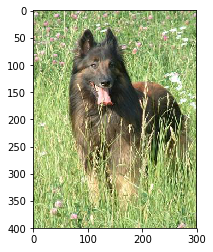

In [32]:
ResNet50_predict_breed('dogImages/test/022.Belgian_tervuren/Belgian_tervuren_01588.jpg')

---
<a id='step5'></a>
## Step 5: Write Dog Classifier Algorithm

Here I write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, it returns the predicted breed.
- if a __human__ is detected in the image, it returns the resembling dog breed.
- if __neither__ is detected in the image, it provides output that indicates neither a human or dog was found.

In [34]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def predict_breed(img_path):
    isDog = dog_detector(img_path)
    isPerson = face_detector(img_path)
    if isDog:
        print("Detected a dog")
        breed = ResNet50_predict_breed(img_path)
        return breed
    if isPerson:
        print("Detected a human face")
        breed = ResNet50_predict_breed(img_path)
        return breed
    else:
        print("No human face or dog detected")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(cv_rgb)

---
<a id='step6'></a>
## Step 6: Test Dog Classifier Algorithm

In this section, we will take our new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

## Results from my Dog Breed Classifier

In [35]:
predict_breed('images/IMG_4667.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'images/IMG_4667.jpg'

Detected a dog
The breed of dog is a Afghan_hound


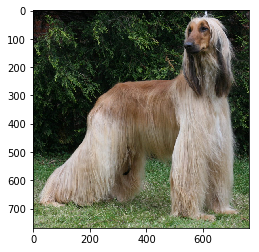

In [36]:
predict_breed('dogImages/train/002.Afghan_hound/Afghan_hound_00081.jpg')

In [37]:
predict_breed('images/beast1.jpeg')

FileNotFoundError: [Errno 2] No such file or directory: 'images/beast1.jpeg'

In [ ]:
predict_breed('images/beast3.jpg')

In [ ]:
predict_breed('images/IMG_0867.jpg')

In [ ]:
predict_breed('images/IMG_4180.jpg')

In [ ]:
predict_breed('images/golden.jpg')

In [ ]:
predict_breed('images/IMG_0941.jpg')

In [ ]:
predict_breed('images/NDP_4565.jpg')

In [ ]:
predict_breed('images/trump.jpg')